In [9]:
# libraries
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [2]:
# load ERA5
store1 = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'
ds1 = xr.open_dataset(store1, engine='zarr', chunks={}).mean(dim="level")[['convective_available_potential_energy',
                                                                           'convective_inhibition',
                                                                           'specific_humidity',
                                                                           'total_precipitation',
                                                                           'temperature',
                                                                           'surface_pressure']]
# precipitation and temperature

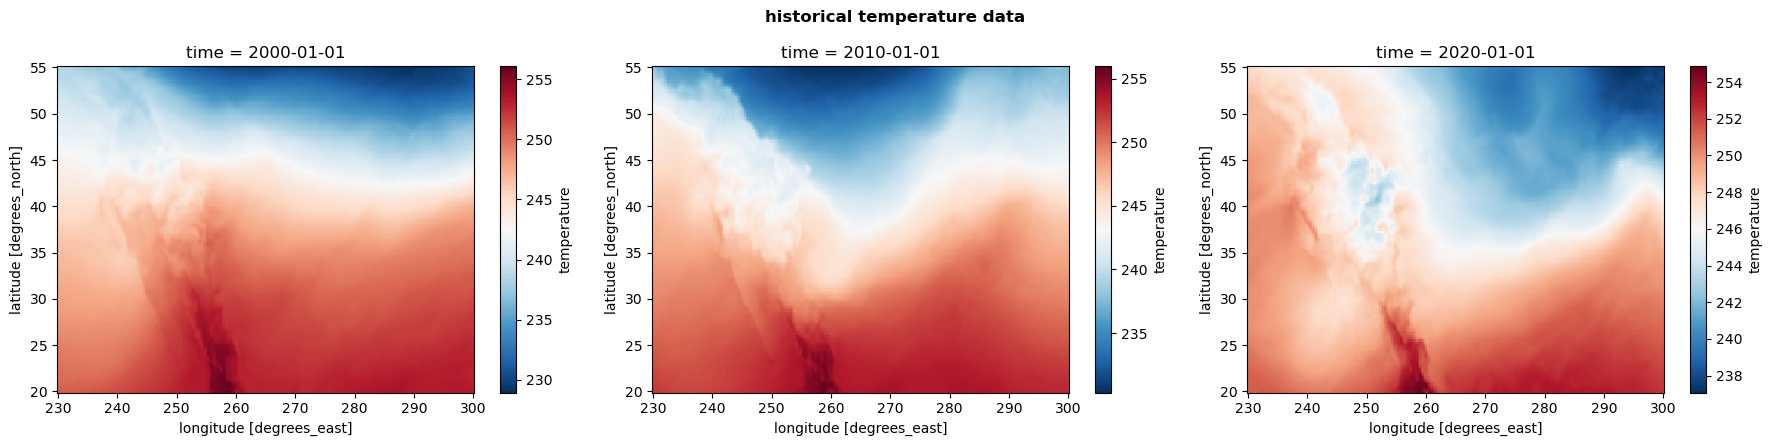

In [3]:
# Area of Interest
lat_min, lat_max = 55, 20
lon_min, lon_max = 230, 300

fig,axes = plt.subplots(figsize=(18,4.5),ncols=3)
yr0, yr1, yr2 = '2000-01-01T00:00:00.000000000', '2010-01-01T00:00:00.000000000', '2020-01-01T00:00:00.000000000'

ds1.sel(time=yr0,latitude=slice(lat_min,lat_max),longitude=slice(lon_min,lon_max)).temperature.plot(ax=axes.flat[0],cmap='RdBu_r')
ds1.sel(time=yr1,latitude=slice(lat_min,lat_max),longitude=slice(lon_min,lon_max)).temperature.plot(ax=axes.flat[1],cmap='RdBu_r')
ds1.sel(time=yr2,latitude=slice(lat_min,lat_max),longitude=slice(lon_min,lon_max)).temperature.plot(ax=axes.flat[2],cmap='RdBu_r')

fig.suptitle('historical temperature data',fontweight='bold')
plt.tight_layout()

### 1. data preprocssing: prepare data for training & test sets

#### import data as training & test sets

Here we train NN using simulations from 3 historical and 3 future scenarios. <br/> Then we test the trained NN using the ssp245 scenario.

In [4]:
# Training set
# First three weeks July 2024
d0_train = '2024-06-01T00:00:00'
d1_train = '2024-06-03T00:00:00'
d0_val = '2024-06-03T00:00:00'
d1_val = '2024-06-04T00:00:00'

X_train_xr = ds1.sel(time=slice(d0_train,d1_val),latitude=slice(lat_min,lat_max),longitude=slice(lon_min,lon_max))
y_train_xr = ds1.sel(time=slice(d0_train,d1_val),latitude=slice(lat_min,lat_max),longitude=slice(lon_min,lon_max))

# Test set
# Last week of July 2024
d0_test = '2024-06-04T00:00:00'
d1_test = '2024-06-05T00:00:00'
X_test_xr = ds1.sel(time=slice(d0_test,d1_test),latitude=slice(lat_min,lat_max),longitude=slice(lon_min,lon_max))
y_test_xr = ds1.sel(time=slice(d0_test,d1_test),latitude=slice(lat_min,lat_max),longitude=slice(lon_min,lon_max))

#### select relevant variables

- predictor: specific humidity
- predictand: convective inhibition

In [5]:
X_train_df = X_train_xr["specific_humidity"].stack({"stacked": ("latitude", "longitude")})
X_train_df = pd.DataFrame(X_train_df.to_pandas())

X_test_df = X_test_xr["specific_humidity"].stack({"stacked": ("latitude", "longitude")})
X_test_df = pd.DataFrame(X_test_df.to_pandas())

y_train_df = y_train_xr["convective_inhibition"].stack({"stacked": ("latitude", "longitude")})
y_train_df = pd.DataFrame(y_train_df.to_pandas())

This is how our predictors & predictand data look like:

In [6]:
X_train_df.head()

latitude                 55.0                                          \
longitude              230.00    230.25    230.50    230.75    231.00   
time                                                                    
2024-06-01 00:00:00  0.001880  0.001889  0.001870  0.001872  0.001895   
2024-06-01 01:00:00  0.001864  0.001881  0.001860  0.001862  0.001888   
2024-06-01 02:00:00  0.001841  0.001869  0.001858  0.001856  0.001863   
2024-06-01 03:00:00  0.001809  0.001839  0.001835  0.001836  0.001840   
2024-06-01 04:00:00  0.001723  0.001761  0.001783  0.001802  0.001819   

latitude                                                               ...  \
longitude              231.25    231.50    231.75    232.00    232.25  ...   
time                                                                   ...   
2024-06-01 00:00:00  0.001918  0.001962  0.001979  0.001988  0.001960  ...   
2024-06-01 01:00:00  0.001913  0.001958  0.001983  0.001998  0.001984  ...   
2024-06-01 02:00:00  0.001884  0.001934  0.001959  0.001977  0.002002  ...   
2024-06-01 03:00:00  0.001849  0.001872  0.001907  0.001948  0.001990  ...   
2024-06-01 04:00:00  0.001827  0.001843  0.001870  0.001900  0.001923  ...   

latitude                 20.0                                          \
longitude              297.75    298.00    298.25    298.50    298.75   
time                                                                    
2024-06-01 00:00:00  0.003741  0.003739  0.003713  0.003687  0.003688   
2024-06-01 01:00:00  0.003780  0.003776  0.003763  0.003749  0.003744   
2024-06-01 02:00:00  0.003810  0.003808  0.003813  0.003807  0.003799   
2024-06-01 03:00:00  0.003839  0.003830  0.003832  0.003826  0.003823   
2024-06-01 04:00:00  0.003882  0.003873  0.003870  0.003854  0.003844   

latitude                                                               
longitude              299.00    299.25    299.50    299.75    300.00  
time                                                                   
2024-06-01 00:00:00  0.003692  0.003707  0.003710  0.003719  0.003706  
2024-06-01 01:00:00  0.003740  0.003741  0.003733  0.003735  0.003714  
2024-06-01 02:00:00  0.003786  0.003775  0.003757  0.003752  0.003734  
2024-06-01 03:00:00  0.003815  0.003798  0.003775  0.003770  0.003756  
2024-06-01 04:00:00  0.003817  0.003791  0.003766  0.003767  0.003761  

[5 rows x 39621 columns]

Note that here we stack the original 2-D tas data into a single dimension (for the purpose of NN implementation)

In [7]:
y_train_df.head()

latitude              55.0                                                   \
longitude           230.00 230.25 230.50 230.75 231.00 231.25 231.50 231.75   
time                                                                          
2024-06-01 00:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2024-06-01 01:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2024-06-01 02:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2024-06-01 03:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2024-06-01 04:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

latitude                           ...        20.0                          \
longitude           232.00 232.25  ...      297.75      298.00      298.25   
time                               ...                                       
2024-06-01 00:00:00    NaN    NaN  ...  269.325806  281.792603  299.966370   
2024-06-01 01:00:00    NaN    NaN  ...  269.493652  278.649200  285.714233   
2024-06-01 02:00:00    NaN    NaN  ...  240.623138  256.218079  260.185486   
2024-06-01 03:00:00    NaN    NaN  ...  223.700623  246.528473  259.178406   
2024-06-01 04:00:00    NaN    NaN  ...  219.748474  227.378113  234.580475   

latitude                                                             \
longitude                298.50      298.75      299.00      299.25   
time                                                                  
2024-06-01 00:00:00  295.495422  294.808746  301.599121  308.740448   
2024-06-01 01:00:00  280.068298  277.550537  280.999146  291.650085   
2024-06-01 02:00:00  249.854996  261.452026  281.990967  279.320618   
2024-06-01 03:00:00  251.747147  255.607727  260.490692  259.056335   
2024-06-01 04:00:00  238.273224  241.965973  250.419586  254.402252   

latitude                                                 
longitude                299.50      299.75      300.00  
time                                                     
2024-06-01 00:00:00  322.733185  308.297913  307.977478  
2024-06-01 01:00:00  300.103699  287.087585  294.442505  
2024-06-01 02:00:00  283.150696  277.275879  272.270813  
2024-06-01 03:00:00  265.816162  266.136597  259.742981  
2024-06-01 04:00:00  261.787720  260.628021  253.562988  

[5 rows x 39621 columns]

#### Data normalization

Let's normalize the input predictors by the mean & std

In [10]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()

X_test = X_test_df.to_numpy()

# Convert to PyTorch datasets
train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_train), \
                                               torch.FloatTensor(y_train))
test_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_test))

# Split into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])